<a href="https://colab.research.google.com/github/marshallekk/Diplo/blob/main/diplo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:


%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
num_epochs = 50
batch_size = 512
learning_rate = 1e-3
use_gpu = True

In [6]:
import numpy as np
from skimage import color

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# converts the PIL image to a pytorch tensor containing an LAB image
def import_image(img):
    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))
    
img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

train_dataset = CIFAR10('./data/CIFAR10', train=True, transform=img_transform, target_transform=None, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10('./data/CIFAR10', train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


In [7]:
class ColorNet(nn.Module):
    def __init__(self, d=128):
        super(ColorNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.conv2_bn = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # out: 128 x 4 x 4
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv5_bn = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1) # out: 128 x 4 x 4
        self.conv6_bn = nn.BatchNorm2d(128)
        self.tconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1) # out: 64 x 8 x 8
        self.tconv1_bn = nn.BatchNorm2d(64)
        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1) # out: 32 x 16 x 16
        self.tconv2_bn = nn.BatchNorm2d(32)
        self.tconv3 = nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1) # out: 2 x 32 x 32

    def forward(self, input):
        x = F.relu(self.conv1_bn(self.conv1(input)))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.relu(self.conv4_bn(self.conv4(x)))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.relu(self.conv6_bn(self.conv6(x)))
        x = F.relu(self.tconv1_bn(self.tconv1(x)))
        x = F.relu(self.tconv2_bn(self.tconv2(x)))
        x = self.tconv3(x)

        return x

cnet = ColorNet()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
cnet = cnet.to(device)

num_params = sum(p.numel() for p in cnet.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))

Number of parameters: 773698


In [8]:
optimizer = torch.optim.Adam(params=cnet.parameters(), lr=learning_rate)

# set to training mode
cnet.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for lab_batch, _ in train_dataloader:
        
        lab_batch = lab_batch.to(device)
        
        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
        
        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 50] average reconstruction error: 174.016219
Epoch [2 / 50] average reconstruction error: 155.978167
Epoch [3 / 50] average reconstruction error: 149.804107
Epoch [4 / 50] average reconstruction error: 145.858961
Epoch [5 / 50] average reconstruction error: 142.062080
Epoch [6 / 50] average reconstruction error: 137.300410
Epoch [7 / 50] average reconstruction error: 132.088032
Epoch [8 / 50] average reconstruction error: 126.568890
Epoch [9 / 50] average reconstruction error: 119.500865
Epoch [10 / 50] average reconstruction error: 113.603102
Epoch [11 / 50] average reconstruction error: 107.768812
Epoch [12 / 50] average reconstruction error: 101.512295
Epoch [13 / 50] average reconstruction error: 96.081340
Epoch [14 / 50] average reconstruction error: 91.311445
Epoch [15 / 50] average reconstruction error: 86.591525
Epoch [16 / 50] average reconstruction error: 82.707925
Epoch [17 / 50] average reconstruction error: 80.001003
Epoch [18 / 50] average reconstr

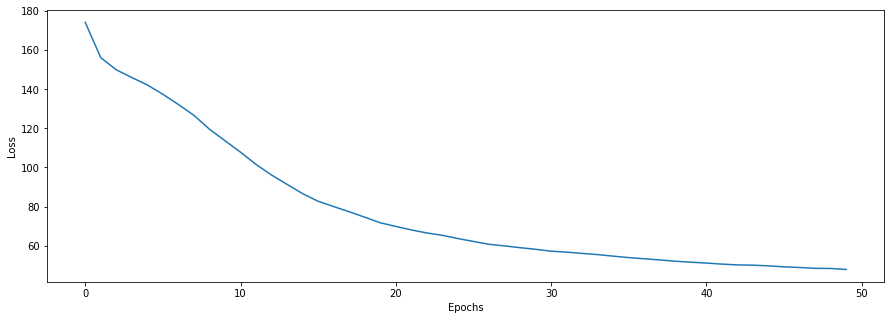

In [9]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure(figsize=(15, 5))
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [10]:
cnet.eval()

test_loss_avg, num_batches = 0, 0
for lab_batch, _ in test_dataloader:

    with torch.no_grad():

        lab_batch = lab_batch.to(device)

        # apply the color net to the luminance component of the Lab images
        # to get the color (ab) components
        predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])

        # loss is the L2 error to the actual color (ab) components
        loss = F.mse_loss(predicted_ab_batch, lab_batch[:, 1:3, :, :])

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average loss: %f' % (test_loss_avg))

average loss: 179.865079


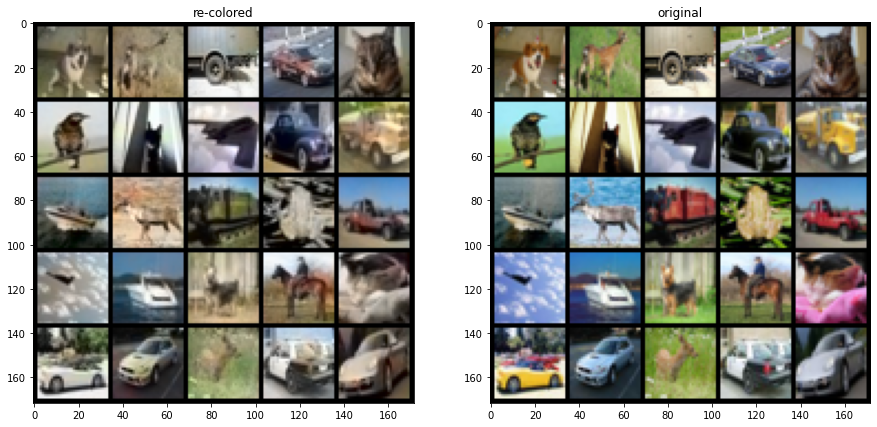

In [11]:
import numpy as np
from skimage import color, io

import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

with torch.no_grad():

    # pick a random subset of images from the test set
    image_inds = np.random.choice(len(test_dataset), 25, replace=False)
    lab_batch = torch.stack([test_dataset[i][0] for i in image_inds])
    lab_batch = lab_batch.to(device)

    # predict colors (ab channels)
    predicted_ab_batch = cnet(lab_batch[:, 0:1, :, :])
    predicted_lab_batch = torch.cat([lab_batch[:, 0:1, :, :], predicted_ab_batch], dim=1)

    lab_batch = lab_batch.cpu()
    predicted_lab_batch = predicted_lab_batch.cpu()

    # convert to rgb
    rgb_batch = []
    predicted_rgb_batch = []
    for i in range(lab_batch.size(0)):
        rgb_img = color.lab2rgb(np.transpose(lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        rgb_batch.append(torch.FloatTensor(np.transpose(rgb_img, (2, 0, 1))))
        predicted_rgb_img = color.lab2rgb(np.transpose(predicted_lab_batch[i, :, :, :].numpy().astype('float64'), (1, 2, 0)))
        predicted_rgb_batch.append(torch.FloatTensor(np.transpose(predicted_rgb_img, (2, 0, 1))))

    # plot images
    fig, ax = plt.subplots(figsize=(15, 15), nrows=1, ncols=2)
    ax[0].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(predicted_rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[0].title.set_text('re-colored')
    ax[1].imshow(np.transpose(torchvision.utils.make_grid(torch.stack(rgb_batch), nrow=5).numpy(), (1, 2, 0)))
    ax[1].title.set_text('original')
    plt.show()